In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np

In [5]:
BATCH_SIZE = 64
IMAGE_SIZE = 32

In [52]:
# Load CIFAR-10 dataset
dataset, info = tfds.load('cifar10', split='train', with_info=True)


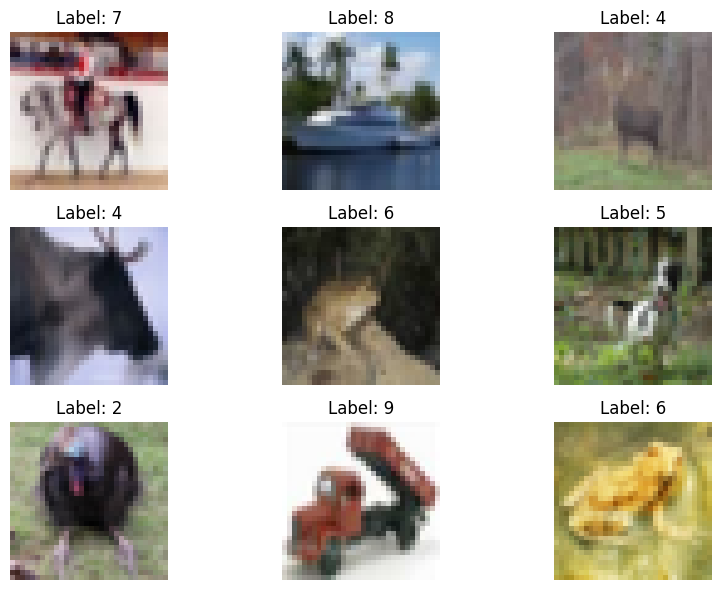

In [53]:
# Code to display images from the dataset
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9, 6))
for i, example in enumerate(dataset.take(9)):
    image, label = example['image'], example['label']
    ax = axes[i // 3, i % 3]
    ax.imshow(image.numpy())
    ax.set_title('Label: {}'.format(label.numpy()))
    ax.axis('off')

plt.tight_layout()
plt.show()

In [15]:
# Convert images to the LAB color mode using OpenCV
def convert2lab(example):
  image = example['image']
  image_lab = tf.numpy_function(func=lambda img: cv.cvtColor(img, cv.COLOR_RGB2LAB), inp=[image], Tout=tf.uint8)
  example['image'] = image_lab
  return example

In [16]:
# Normalize data to one so that neural network learns faster
def normalize_lab(example):
  image = example['image']
  image /= 255
  example['image'] = image
  return example

In [17]:
# Turning LAB image back to RGB
def back_to_rgb(example):
  image = example['image']
  image *= 255
  image_lab = tf.numpy_function(func=lambda img: cv.cvtColor(img, cv.COLOR_LAB2RGB), inp=[image], Tout=tf.uint8)
  example['image'] = image_lab
  return example

In [18]:
def feature_label_split(example):
  example['features_input'] = example['image'][:, :, 0]
  example['labels'] = example['image'][:, :, 1:]
  del example['image']
  del example['label']
  del example['id']

  return example


In [19]:
def expand(example):
  example['features_input'] = tf.reshape(example['features_input'], shape=[32, 32, 1])
  return example

In [54]:
dataset = dataset.map(convert2lab)

In [55]:
dataset = dataset.map(normalize_lab)

In [56]:
dataset = dataset.map(feature_label_split)

In [57]:
dataset = dataset.map(expand)

In [24]:
def features_column(element):
  return element['features_input']

def validation_column(element):
  return element['labels']

ds_features = dataset.map(lambda x: features_column(x))
ds_validation = dataset.map(lambda x: validation_column(x))

np_features = np.array(list(ds_features.as_numpy_iterator()))
np_validation = np.array(list(ds_validation.as_numpy_iterator()))



In [58]:
new_dataset = tf.data.Dataset.from_tensor_slices((np_features, np_validation))

In [59]:
new_dataset = new_dataset.cache()
new_dataset = new_dataset.shuffle(60000)
new_dataset = new_dataset.batch(BATCH_SIZE)
new_dataset = new_dataset.prefetch(32)

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, MaxPooling2D, Dropout

In [33]:
model = Sequential()

# Encoder
model.add(Conv2D(64, (3, 3), input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1), activation='relu', padding='same', name='features'))
model.add(Dropout(.3))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Dropout(.3))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Dropout(.3))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Dropout(.3))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())

# Decoder
model.add(Conv2DTranspose(128, (3, 3), strides=(2, 2), activation='relu', padding='same'))
model.add(Dropout(.3))


model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Dropout(.3))

model.add(BatchNormalization())
model.add(Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu', padding='same'))
model.add(Dropout(.3))

model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Dropout(.3))
model.add(BatchNormalization())

# Output layer
model.add(Conv2D(2, (1, 1), activation='sigmoid', padding='same'))

In [34]:
model.input_shape

(None, 32, 32, 1)

In [35]:
model.output_shape

(None, 32, 32, 2)

In [36]:
model.input_names

['features_input']

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 features (Conv2D)           (None, 32, 32, 64)        640       
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 batch_normalization (Batch  (None, 32, 32, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        36928     
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 64)        0         
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 64)        256       
 chNormalization)                                       

In [38]:
model.compile(optimizer='adam',
              loss='MSE',
              metrics=['accuracy'])

In [61]:
new_dataset.as_numpy_iterator().next()[0].shape

(64, 32, 32, 1)

In [ ]:
model.fit(new_dataset, epochs=1)

 21/782 [..............................] - ETA: 34:24 - loss: 0.0182 - accuracy: 0.5483

In [ ]:
# Display dataset examples
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
for i, example in enumerate(dataset.take(15)):
    image, label = example['image'], example['label']
    ax = axes[i // 5, i % 5]
    ax.imshow(image.numpy())
    ax.set_title('Label: {}'.format(label.numpy()))
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Converting back to RGB.
L = np_features[6] * 255 # Lightness channel
ab = np_validation[6] * 255 # A and B channels

L = L.astype(np.uint8)
ab = ab.astype(np.uint8)

LAB = np.concatenate([L, ab], axis=2)

RGB = cv.cvtColor(LAB, cv.COLOR_Lab2RGB)

In [ ]:
model.save("color.keras")

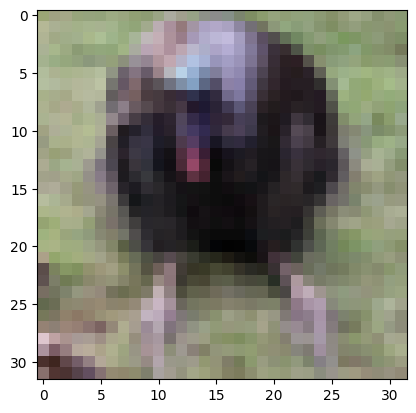

In [ ]:
plt.imshow(RGB)

In [ ]:
# Converting back to RGB.
L = np_features[6] * 255 # Lightness channel
ab = np_validation[6] * 255 # A and B channels

L = L.astype(np.uint8)
ab = ab.astype(np.uint8)

LAB = np.concatenate([L, ab], axis=2)

RGB = cv.cvtColor(LAB, cv.COLOR_Lab2RGB)

In [ ]:
a = model.predict()

In [ ]:
a = model.predict(np.expand_dims(np_features[6], axis=0))

1/1 [==============================] - 1s 867ms/step


In [ ]:
a[0]

NameError: name 'a' is not defined